In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.nn import Linear


In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [4]:
def get_graph_report(dataset):
    "graph report"
    print()
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

def get_cc_report(cc):
    "connected component report"
    print()
    print(cc)
    print('===========================================================================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {cc.num_nodes}')
    print(f'Number of edges: {cc.num_edges}')
    print(f'Average node degree: {cc.num_edges / cc.num_nodes:.2f}')
    print(f'Number of training nodes: {cc.train_mask.sum()}')
    print(f'Training node label rate: {int(cc.train_mask.sum()) / cc.num_nodes:.2f}')
    print(f'Has isolated nodes: {cc.contains_isolated_nodes()}')
    print(f'Has self-loops: {cc.contains_self_loops()}')
    print(f'Is undirected: {cc.is_undirected()}')

In [5]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [6]:
get_graph_report(dataset)


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [7]:
get_cc_report(data)


Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [8]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [9]:
model = GCN(hidden_channels=16)
model.eval()



GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

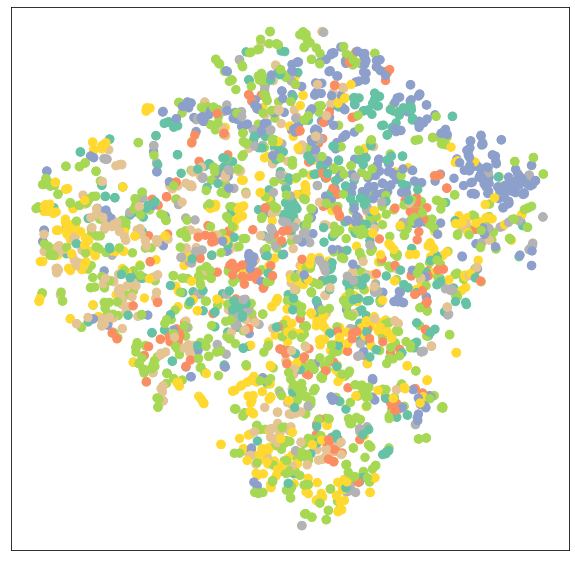

In [10]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [20]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9457
Epoch: 002, Loss: 1.9395
Epoch: 003, Loss: 1.9344
Epoch: 004, Loss: 1.9264
Epoch: 005, Loss: 1.9176
Epoch: 006, Loss: 1.9112
Epoch: 007, Loss: 1.8986
Epoch: 008, Loss: 1.8882
Epoch: 009, Loss: 1.8807
Epoch: 010, Loss: 1.8648
Epoch: 011, Loss: 1.8532
Epoch: 012, Loss: 1.8386
Epoch: 013, Loss: 1.8307
Epoch: 014, Loss: 1.8121
Epoch: 015, Loss: 1.7944
Epoch: 016, Loss: 1.7753
Epoch: 017, Loss: 1.7677
Epoch: 018, Loss: 1.7408
Epoch: 019, Loss: 1.7327
Epoch: 020, Loss: 1.7162
Epoch: 021, Loss: 1.6801
Epoch: 022, Loss: 1.6871
Epoch: 023, Loss: 1.6724
Epoch: 024, Loss: 1.6303
Epoch: 025, Loss: 1.6215
Epoch: 026, Loss: 1.5965
Epoch: 027, Loss: 1.5954
Epoch: 028, Loss: 1.5550
Epoch: 029, Loss: 1.5388
Epoch: 030, Loss: 1.5133
Epoch: 031, Loss: 1.4847
Epoch: 032, Loss: 1.4779
Epoch: 033, Loss: 1.4534
Epoch: 034, Loss: 1.4301
Epoch: 035, Loss: 1.3986
Epoch: 036, Loss: 1.3949
Epoch: 037, Loss: 1.3755
Epoch: 038, Loss: 1.3620
Epoch: 039, Loss: 1.3023
Epoch: 040, Loss: 1.2593


In [21]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


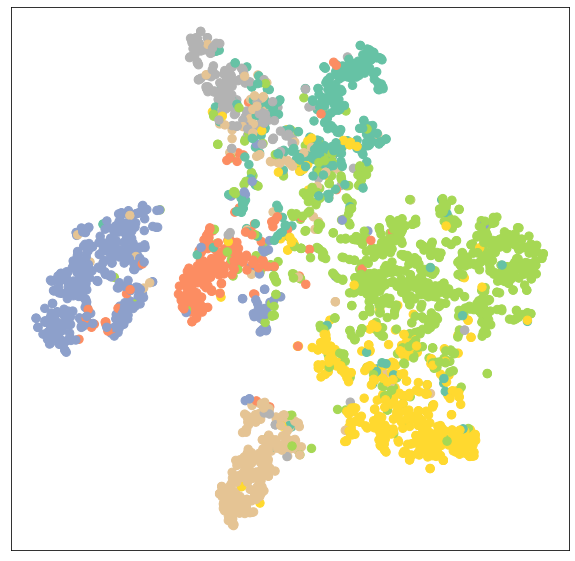

In [22]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)